In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 


import torch_geometric
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, GraphUNet
from torch_geometric.data import Batch
from torch_geometric.utils import to_dense_adj
from tqdm import tqdm


from utils.data import GraphDataModule, save_prediction
from utils.training import train_model
from utils.metrics import evaluate_model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
data_module = GraphDataModule("./data", num_workers=1, batch_size=1)
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

Time taken to load ./data/hr_train.csv: 3.856825590133667 seconds
Time taken to load ./data/lr_train.csv: 0.8724327087402344 seconds
Time taken to load ./data/lr_test.csv: 0.434659481048584 seconds


Converting vectors to graphs: 100%|██████████| 112/112 [00:00<00:00, 747.29it/s]


In [5]:
def compute_PCA(batch, n_components=None):
    cov_matrix = to_dense_adj(batch.edge_index, edge_attr=batch.edge_attr, batch=batch.batch)
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)
    
    return {
        'eigenvalues': eigenvalues.squeeze(),
        'eigenvectors': eigenvectors.squeeze()
    }

In [6]:
batch,target_batch = next(iter(train_loader))
input_dim = batch[0].x.shape[0]
output_dim = target_batch[0].x.shape[0]
input_features = batch[0].x.shape[1]
print(input_features,input_dim,output_dim)

1 160 268


In [7]:
def compute_list_features(batch_list,ncomp):
    A_list = [
        to_dense_adj(batch.edge_index, edge_attr=batch.edge_attr, batch=batch.batch)
        for batch in batch_list
    ]
    A = torch.zeros_like(A_list[0])
    for a in A_list: A += a
    
    eigenvalues, eigenvectors = torch.linalg.eigh(A)
    
    eigenvalues = eigenvalues.squeeze()
    eigenvectors = eigenvectors.squeeze()
    # Get indices of top ncomp largest absolute eigenvalues
    _, top_indices = torch.topk(eigenvalues.abs(), k=ncomp)
    Q = eigenvectors[:,top_indices]

    return Q


In [8]:
def project_adj(batch, Q):
    A = to_dense_adj(batch.edge_index, edge_attr=batch.edge_attr, batch=batch.batch).squeeze()
    C = (Q.t() @ A @ Q).to(torch.cfloat)
    C = torch.diag(torch.diag(C))
    C = C ** (1/2)
    return Q.to(torch.cfloat) @ C

In [9]:
def compute_features(batch, ncomp):
    pca_batch = compute_PCA(batch)
    
    # Get absolute eigenvalues and sort them in descending order
    abs_eigenvalues = pca_batch["eigenvalues"].abs()
    
    # Get indices of top ncomp largest absolute eigenvalues
    _, top_indices = torch.topk(abs_eigenvalues, k=ncomp)
    
    # Select eigenvectors and eigenvalues corresponding to top ncomp
    Q = pca_batch["eigenvectors"][:,top_indices].to(torch.cfloat)
    D = torch.diag(pca_batch["eigenvalues"]).to(torch.cfloat)
    D2 = D ** (1/2)
    D2 = D2[:,top_indices][top_indices,:]
    Q2 = Q @ D2
    
    return Q2, Q

In [14]:
batch_list = [batch for batch,_ in iter(train_loader)]
target_list = [batch for _,batch in iter(train_loader)]
Q1 = compute_list_features(batch_list, 128)
Q2 = compute_list_features(target_list, 256)

mean_list = []
for batch,_ in val_loader:
    Q0 = project_adj(batch, Q1)

    cov_hat = (Q0 @ Q0.t()).to(torch.float)
    cov = to_dense_adj(batch.edge_index, edge_attr=batch.edge_attr, batch=batch.batch).squeeze()

    mean_list.append(torch.mean((cov_hat-cov).abs()).item())

np.mean(mean_list)


np.float64(0.12389832756975118)

In [ ]:
from torch.nn import Linear, BatchNorm1d, Dropout, TransformerEncoder, TransformerEncoderLayer
from torch_geometric.nn import GATConv, GCNConv, GINConv, global_add_pool




class UpscalerGNN(nn.Module):
    def __init__(self, hidden_size, hidden_layers, Q1,Q2):
        super().__init__()
        self.Q1 = Q1
        self.Q2 = Q2
        self.input_nodes = 160
        self.output_nodes = 268
        

        self.layers = nn.ModuleList()
        self.layers.append(
            nn.Sequential(
                nn.Linear(in_features=128, out_features=hidden_size),
                nn.BatchNorm1d(num_features=hidden_size),
                nn.Dropout(p=0.1),
                nn.LeakyReLU()
            )
        )

        for _ in range(hidden_layers):
            self.layers.append(
                nn.Sequential(
                    nn.Linear(in_features=hidden_size, out_features=hidden_size),
                    nn.BatchNorm1d(num_features=hidden_size),
                    nn.Dropout(p=0.1),
                    nn.LeakyReLU()
                )
            )

        self.layers.append(
            nn.Sequential(
                nn.Linear(in_features=hidden_size, out_features=256),
                nn.BatchNorm1d(num_features=hidden_size),
                nn.Dropout(p=0.1),
                nn.LeakyReLU()
            )
        )
        
        

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, samples: Batch): 
        A = to_dense_adj(batch.edge_index, edge_attr=batch.edge_attr, batch=batch.batch).squeeze().to(self.device)
        C = self.Q1.t() @ A @ self.Q1
        C = C.squeeze()
        C = torch.diag(C).unsqueeze(0)

        for layer in self.layers:
            C = layer(C)

        C = torch.diag(C.squeeze())
        return self.Q2 @ C @ self.Q2.t()


In [29]:
model = UpscalerGNN(
    hidden_size=256, 
    hidden_layers=1,
    Q1=Q1.to(device),
    Q2=Q2.to(device)
).to(device)

In [30]:
criterion = nn.L1Loss()

train_loss_history, val_loss_history, lr_history, best_model_state_dict = train_model(
    model=model, 
    train_dataloader=train_loader, 
    val_dataloader=val_loader,
    criterion=criterion,
    num_epochs=100,
    lr=0.01
)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: expected 2D or 3D input (got 1D input)

In [8]:
model.load_state_dict(best_model_state_dict)
loss = evaluate_model(model, val_loader)
print(loss)

torch.save(model, 'model.pth')

0.19591764


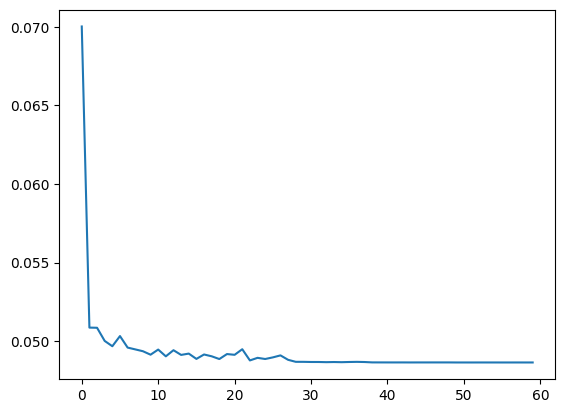

In [9]:
plt.plot(train_loss_history)
plt.show()

In [54]:
model = torch.load("model.pth", weights_only=False)

In [55]:
test_dataloader = data_module.test_dataloader()

In [57]:
submission_file = "outputs/test/submission.csv"
save_prediction(model, test_dataloader, submission_file)

(112, 0)


In [ ]:
df = pd.read_csv(submission_file)

In [ ]:
#!kaggle competitions submit -c dgl-2025-brain-graph-super-resolution-challenge -f outputs/test/submission.csv -m "test"
